In [11]:
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arasekin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\arasekin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [24]:
df= pd.read_csv('archive/CEAS_08.csv')

In [25]:
df.head()

,sender,receiver,date,subject,body,label,urls
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1


In [26]:
df = df.drop(['subject', 'sender', 'date', 'urls', 'receiver'],  axis=1)

In [27]:
df.isnull().sum()

body     0
label    0
dtype: int64

In [28]:
X_train, X_test, y_train, y_test = train_test_split(df['body'], df['label'], test_size=0.2, random_state=42)

In [29]:
X_train

10951    \nBe the stud in 2008, and achieve all your dr...
8668     \nDear 8413c360d9ee0da1bf63d573b84c4a5e\n\nSum...
8200     Impress your coworkers and friends with an ele...
14981    Mike McMullin wrote:\n> On Sat, 2008-02-16 at ...
23343    Thanks for the reply. I am not sure what infor...
                               ...                        
6265     introducing 'mixed', a module providing a clas...
11284    \nHave you always dreamed of owning your own h...
38158    On Thursday 06 March 2008 16:30, Oddball wrote...
860      \nCan you afford to lose 300,000 potential cus...
15795    \n============================================...
Name: body, Length: 31323, dtype: object

In [30]:
def text_preprocess(ds: pd.Series) -> pd.Series:
    ds = ds.str.lower()
    ds = ds.str.replace(r'[^a-zA-Z\s]+', '', regex=True)
    ds = ds.str.split()
    ds = ds.apply(lambda x: [word for word in x if word not in stopwords.words('english')])
    lemmatizer = WordNetLemmatizer()
    ds = ds.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    ds = ds.str.join(' ')
    return ds

X_train = text_preprocess(X_train)


In [31]:
if isinstance(X_train, pd.Series):
    # If X_train is a Series
    X_train.to_csv('preprocessed_X_train.csv', index=False, header=True)
elif isinstance(X_train, pd.DataFrame):
    # If X_train is a DataFrame
    X_train.to_csv('preprocessed_X_train.csv', index=False)
else:
    # If X_train is a list or numpy array
    pd.DataFrame(X_train, columns=['preprocessed_text']).to_csv('preprocessed_X_train.csv', index=False)

print("Preprocessed X_train has been saved to 'preprocessed_X_train.csv'")

Preprocessed X_train has been saved to 'preprocessed_X_train.csv'


In [32]:
X_train

10951    stud achieve dream super size read hundred tes...
8668     dear cdeedabfdbcae summer great time take brea...
8200     impress coworkers friend elegant stylish expen...
14981    mike mcmullin wrote sat herbert graeber wrote ...
23343    thanks reply sure information need ask need so...
                               ...                        
6265     introducing mixed module providing class handl...
11284    always dreamed owning high dollar famous brand...
38158    thursday march oddball wrote paul ollion schre...
860      afford lose potential customer per year would ...
15795    fm th international symposium formal method au...
Name: body, Length: 31323, dtype: object

In [33]:
X_test = text_preprocess(X_test)

In [34]:
# Fit the TF-IDF vectorizer on the training data only
tfidf_vectorizer = TfidfVectorizer(max_features=100, 
                                   #ngram_range=(1, 2)
                                   )
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data using the already fitted vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test)

tfidf_vectorizer.get_feature_names_out()

print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(31323, 100)
(7831, 100)


In [35]:
# Train a Logistic Regression model
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96      3490
           1       0.95      0.98      0.97      4341

    accuracy                           0.96      7831
   macro avg       0.96      0.96      0.96      7831
weighted avg       0.96      0.96      0.96      7831



In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      0.97      0.98      3490
           1       0.98      0.99      0.98      4341

    accuracy                           0.98      7831
   macro avg       0.98      0.98      0.98      7831
weighted avg       0.98      0.98      0.98      7831



In [37]:

# Feature Importance
feature_importance = model.feature_importances_
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

# Sort features by importance
sorted_idx = np.argsort(feature_importance)
sorted_features = feature_names[sorted_idx]
sorted_importance = feature_importance[sorted_idx]

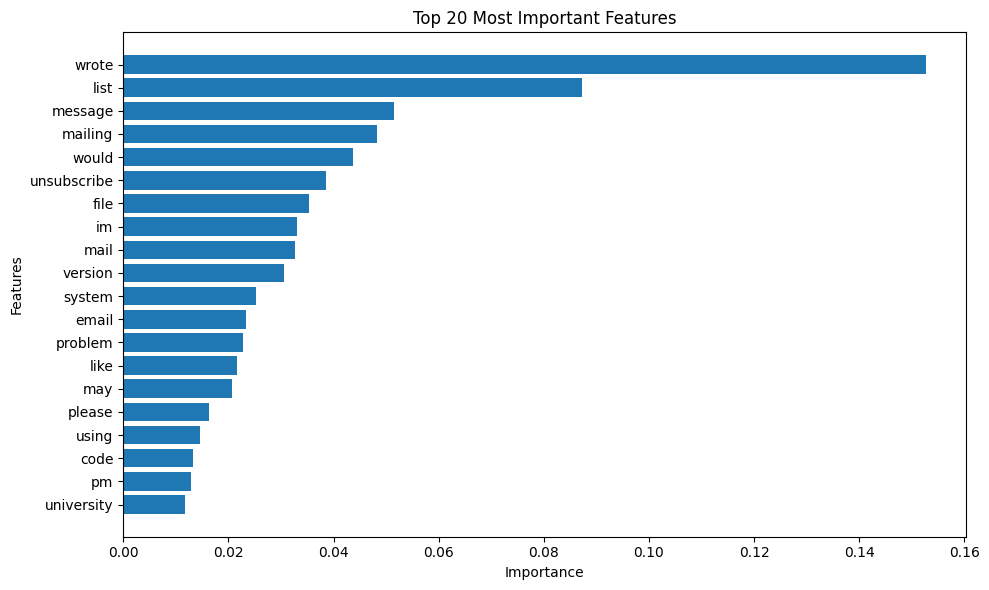

wrote: 0.1527
list: 0.0872
message: 0.0515
mailing: 0.0483
would: 0.0436
unsubscribe: 0.0385
file: 0.0353
im: 0.0330
mail: 0.0327
version: 0.0305
system: 0.0253
email: 0.0234
problem: 0.0229
like: 0.0216
may: 0.0207
please: 0.0163
using: 0.0147
code: 0.0132
pm: 0.0129
university: 0.0118


In [38]:
plt.figure(figsize=(10, 6))
plt.barh(range(20), sorted_importance[-20:])
plt.yticks(range(20), sorted_features[-20:])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 20 Most Important Features')
plt.tight_layout()
plt.show()

# Print top 20 most important features
top_20_features = list(zip(sorted_features[-20:], sorted_importance[-20:]))
for feature, importance in reversed(top_20_features):
    print(f"{feature}: {importance:.4f}")

# Save feature importance to a CSV file
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
feature_importance_df.to_csv('feature_importance.csv', index=False)

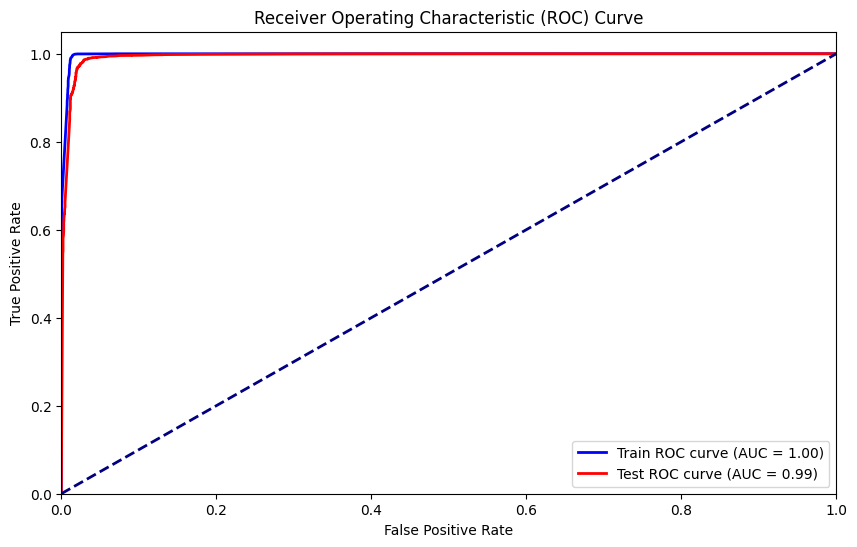

AUC-ROC score for training set: 0.9979
AUC-ROC score for test set: 0.9942


In [39]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get probabilities for positive class
y_train_pred_proba = model.predict_proba(X_train_tfidf)[:, 1]
y_test_pred_proba = model.predict_proba(X_test_tfidf)[:, 1]

# Compute ROC curve and AUC for training set
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
roc_auc_train = auc(fpr_train, tpr_train)

# Compute ROC curve and AUC for test set
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"AUC-ROC score for training set: {roc_auc_train:.4f}")
print(f"AUC-ROC score for test set: {roc_auc_test:.4f}")